# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks=pd.read_parquet('tracks.parquet')
catalog_names=pd.read_parquet('catalog_names.parquet')
interactions=pd.read_parquet('interactions.parquet')

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [4]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [5]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [6]:
print(tracks.dtypes)
print(catalog_names.dtypes)
print(interactions.dtypes)

track_id     int64
albums      object
artists     object
genres      object
dtype: object
id       int64
type    object
name    object
dtype: object
user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object


In [3]:
import numpy as np

def is_empty(x):
    if isinstance(x, (list, np.ndarray)):
        return len(x) == 0
    return True

tracks['artists_empty'] = tracks['artists'].apply(is_empty)
tracks['genres_empty'] = tracks['genres'].apply(is_empty)
tracks['albums_empty'] = tracks['albums'].apply(is_empty)

In [4]:
print(tracks['artists_empty'].sum())
print(tracks['genres_empty'].sum())
print(tracks['albums_empty'].sum())

15369
3687
18


In [9]:
print("tracks: уникальных track_id:", tracks['track_id'].nunique(), "всего строк:", len(tracks))
print("catalog_names: уникальных id:", catalog_names['id'].nunique(), "всего строк:", len(catalog_names))
print("interactions: уникальных user_id:", interactions['user_id'].nunique(), "уникальных track_id:", interactions['track_id'].nunique())

tracks: уникальных track_id: 1000000 всего строк: 1000000
catalog_names: уникальных id: 1776697 всего строк: 1812471
interactions: уникальных user_id: 1373221 уникальных track_id: 1000000


In [10]:
catalog_names[catalog_names['id'].duplicated()].head()

,id,type,name
658728,12,artist,Phil Everly
658735,34,artist,Miles Davis
658736,36,artist,Baker
658741,87,artist,Michael Schenker
658744,93,artist,Femi Kuti


In [11]:
catalog_names[catalog_names['id'] == 12] # отличие в типе 

,id,type,name
1,12,album,Wild Young Hearts
658728,12,artist,Phil Everly
812317,12,genre,shanson


In [12]:
catalog_names['type'].value_counts()

track     1000000
album      658724
artist     153581
genre         166
Name: type, dtype: int64

# Выводы

Явные проблемы:
- В таблице tracks встречаются треки без исполнителей, жанров и альбомов.

Решение:
- Удалить треки без исполнителей. Для пропусков жанрах заменить на -1. Пропуски в альбомах уйдут с треками без исполнителей.
- Из таблицы interactions удалить записи с track_id, которых не будет  в tracks.

In [13]:
set(interactions['track_id']) - set(tracks['track_id'])

set()

In [4]:
tracks = tracks[~tracks['artists_empty']].reset_index(drop=True)

In [5]:
mask = tracks['genres_empty']
tracks.loc[mask, 'genres'] = tracks.loc[mask, 'genres'].apply(
    lambda x: list(x) + [-1] if isinstance(x, (list, np.ndarray)) else [-1]
)

In [ ]:
len(set(interactions['track_id']) - set(tracks['track_id']))

15369

In [6]:
interactions = interactions[interactions['track_id'].isin(tracks['track_id'])].reset_index(drop=True)

In [27]:
len(set(interactions['track_id']) - set(tracks['track_id']))

0

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

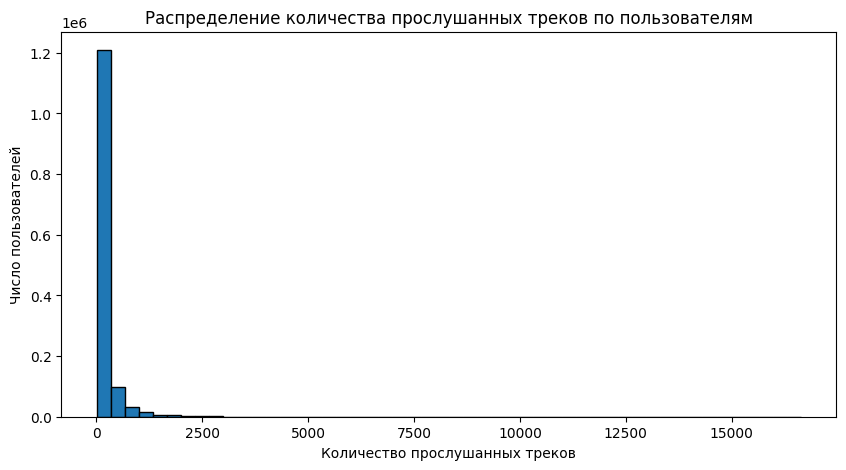

In [28]:
track_counts = interactions.groupby('user_id')['track_id'].count()
plt.figure(figsize=(10, 5))
plt.hist(track_counts, bins=50, edgecolor='k')
plt.xlabel('Количество прослушанных треков')
plt.ylabel('Число пользователей')
plt.title('Распределение количества прослушанных треков по пользователям')
plt.show()

Наиболее популярные треки

In [29]:
interactions['track_id'].value_counts().head(10)

53404       111062
33311009    106921
178529      101924
35505245     99490
65851540     86670
24692821     86246
32947997     85886
51241318     85244
795836       85042
45499814     84748
Name: track_id, dtype: int64

Наиболее популярные жанры

In [31]:
merged = interactions.merge(tracks[['track_id', 'albums', 'artists', 'genres']], on='track_id', how='left')

In [34]:
from collections import Counter
all_genres = [genre for sublist in merged['genres'] for genre in sublist]
genre_counts = Counter(all_genres)
most_common_genres = genre_counts.most_common(10)

In [37]:
most_common_genres

[(11, 55578305),
 (75, 37799821),
 (102, 31091989),
 (20, 26626234),
 (3, 25303695),
 (68, 20120694),
 (16, 16291557),
 (2, 13166147),
 (14, 12772620),
 (47, 12437375)]

Треки, которые никто не прослушал

In [44]:
len(set(interactions['track_id']) - set(tracks['track_id']))

0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [7]:
items = tracks.copy()
events = interactions.copy()

In [8]:
items = items.rename({'track_id': 'item_id'}, axis=1)[['item_id', 'albums', 'artists', 'genres']]

In [9]:
events = events.rename({'track_id': 'item_id'}, axis=1)

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [2]:
items.to_parquet('recsys/data/items.parquet')
events.to_parquet('recsys/data/events.parquet')

NameError: name 'items' is not defined

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [13]:
del tracks
del interactions

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
items = pd.read_parquet('recsys/data/items.parquet')
events = pd.read_parquet('recsys/data/events.parquet')

In [4]:
catalog_names=pd.read_parquet('catalog_names.parquet')

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [5]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16").date()

train_test_global_time_split_idx = events["started_at"] < pd.Timestamp(train_test_global_time_split_date)
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test =  events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users))

1342147 782296 751644


In [5]:
len(events_test)/len(events)*100

6.233740020664246

In [6]:
cold_users = set(users_test) - set(users_train)
print(len(cold_users)) 

30652


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [31]:
# Найти пользователей, которые слушали один и тот же трек более одного раза
user_track_counts = events.groupby(['user_id', 'item_id']).size().reset_index(name='plays')
user_track_counts.loc[user_track_counts['plays'] > 1, 'user_id'].unique()

array([], dtype=int64)

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
item_popularity = events_train \
    .groupby("item_id") \
    .agg(users=("user_id", "nunique")) \
    .reset_index()

scaler = MinMaxScaler()
item_popularity["users_norm"] = scaler.fit_transform(item_popularity[["users"]])
item_popularity["popularity_score"] = item_popularity["users_norm"]
item_popularity = item_popularity.sort_values("popularity_score", ascending=False)

In [18]:
top_popular = item_popularity.head(10)

In [19]:
top_popular.to_parquet("recsys/recommendations//top_popular.parquet")

In [41]:
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_popular, on="item_id", how="left")

cold_user_items_no_items_idx = cold_users_events_with_recs["users"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_items_idx] \
    [["user_id", "item_id", "users"]] 

In [42]:
len(cold_user_recs)/len(events_test)*100

0.43890062222981546

# Персональные

Рассчитаем персональные рекомендации.

In [20]:
import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/tmp/ipykernel_3245/1044897688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_3245/1044897688.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_3245/1044897688.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [22]:
events_train['weight'] = 1.0 # все взаимодействия = 1
events_test['weight'] = 1.0

/tmp/ipykernel_3245/370190247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['weight'] = 1.0 # все взаимодействия = 1
/tmp/ipykernel_3245/370190247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test['weight'] = 1.0


In [23]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["weight"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [24]:
from implicit.als import AlternatingLeastSquares
# меньше факторов и итерейшн изза памяти
als_model = AlternatingLeastSquares(factors=10, iterations=5, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

/home/mle-user/mle-sprint4-project/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/mle-sprint4-project/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 5/5 [02:03<00:00, 24.61s/it]


In [25]:
user_ids_encoded = range(len(user_encoder.classes_))

In [26]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=10) 

In [27]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [28]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("recsys/recommendations/als_recommendations.parquet")

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [29]:
max_similar_items = 2
train_item_ids_enc = events_train['item_id_enc'].unique()

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

In [30]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score":sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [31]:
similar_items.to_parquet("recsys/recommendations/similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [2]:
top_popular = pd.read_parquet("recsys/recommendations/top_popular.parquet")
als_recommendations = pd.read_parquet("recsys/recommendations/als_recommendations.parquet")
similar_items = pd.read_parquet("recsys/recommendations/similar.parquet")

In [33]:
top_popular

,item_id,users,users_norm,popularity_score
9098,53404,110026,1.000000,1.000000
483849,33311009,101076,0.918655,0.918655
26665,178529,100866,0.916746,0.916746
512119,35505245,95523,0.868185,0.868185
368048,24692821,84153,0.764844,0.764844
90461,795836,83749,0.761172,0.761172
197262,6705392,80608,0.732624,0.732624
475262,32947997,80243,0.729307,0.729307
6558,37384,79512,0.722663,0.722663
647197,45499814,78564,0.714047,0.714047


In [34]:
als_recommendations.head()

,user_id,item_id,score
0,0,178529,0.007453
1,0,53404,0.007110
2,0,35505245,0.006170
3,0,148345,0.005718
4,0,795836,0.005322


In [23]:
similar_items.head()

,score,item_id_1,item_id_2
1,0.987896,99262,67534616
2,0.984905,99262,20266461
4,0.994643,589498,589457
5,0.990984,589498,590865
7,0.996411,590262,590303


In [6]:
users=events_train['user_id'].unique()
top_cand = (top_popular.assign(key=1).merge(pd.DataFrame({
    "user_id": users, "key":1
}), on="key").drop("key", axis=1))
candidates = als_recommendations.merge(top_cand, on=['user_id', 'item_id'], how='outer')
candidates['als_score'] = candidates['score']
candidates = candidates[['user_id', 'item_id', 'popularity_score', 'als_score']].drop_duplicates(subset=['user_id', 'item_id'])
user_item_train = (
    events_train.assign(was_listened_before=1)[['user_id', 'item_id', 'was_listened_before']]
)
candidates = candidates.merge(user_item_train, on=['user_id', 'item_id'], how="left")
candidates['was_listened_before'] = candidates['was_listened_before'].fillna(0)
# Преобразуем признаки в items
items['n_genres'] = items['genres'].apply(lambda x: len(x))
items['n_artists'] = items['artists'].apply(lambda x: len(x))
items['n_albums'] = items['albums'].apply(lambda x: len(x))

def get_first(lst):
    return lst[0]


items['first_artist'] = items['artists'].apply(lambda x: x[0])
items['first_genre'] = items['genres'].apply(lambda x: x[0])
# Добавим эти признаки к кандидатам
candidates = candidates.merge(
    items[['item_id', 'n_genres', 'n_artists', 'n_albums', 'first_artist', 'first_genre']],
    on='item_id', how='left'
)
candidates['was_listened_before']=candidates['was_listened_before'].astype("int")

NameError: name 'top_popular' is not defined

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [ ]:
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["was_listened_before"].sum() > 0)

In [ ]:
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("was_listened_before == 1"),
    candidates_to_sample.query("was_listened_before == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(min(negatives_per_user, len(x)), random_state=0))
    ]) 

In [61]:
candidates_for_train.head()

,user_id,item_id,popularity_score,als_score,was_listened_before,n_genres,n_artists,n_albums,first_artist,first_genre
17,1,32291816,NaN,0.014086,1,1,1,1,3315646,50
30,3,35505245,0.868185,0.157236,1,2,2,2,4611844,3
32,3,50834580,NaN,0.126053,1,2,1,2,5129397,3
33,3,49961817,NaN,0.123843,1,2,2,3,666984,11
36,3,39307896,NaN,0.115957,1,2,1,2,5129397,3


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
# задаём имена колонок признаков и таргета
features = ['popularity_score', 'als_score', 'n_genres', 'n_artists','n_albums', 'first_artist', 'first_genre']
target = 'was_listened_before'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6700921	total: 391ms	remaining: 3.52s
9:	learn: 0.5779601	total: 2.8s	remaining: 0us


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [68]:
users_test=events_test['user_id'].unique()
top_cand_test = (top_popular.assign(key=1).merge(pd.DataFrame({
    "user_id": users_test, "key":1
}), on="key").drop("key", axis=1))
candidates_test = als_recommendations.merge(top_cand_test, on=['user_id', 'item_id'], how='outer')
candidates_test['als_score'] = candidates_test['score']
candidates_test = candidates_test[['user_id', 'item_id', 'popularity_score', 'als_score']].drop_duplicates(subset=['user_id', 'item_id'])
user_item_test = (
    events_test.assign(was_listened_before=1)[['user_id', 'item_id', 'was_listened_before']]
)
candidates_test = candidates_test.merge(user_item_test, on=['user_id', 'item_id'], how="left")
candidates_test['was_listened_before'] = candidates_test['was_listened_before'].fillna(0)

# Добавим эти признаки к кандидатам
candidates_test = candidates_test.merge(
    items[['item_id', 'n_genres', 'n_artists', 'n_albums', 'first_artist', 'first_genre']],
    on='item_id', how='left'
)
candidates_test['was_listened_before']=candidates_test['was_listened_before'].astype("int")

In [71]:
candidates_to_rank = candidates_test[candidates_test["user_id"].isin(events_train["user_id"].drop_duplicates())]

In [73]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 100
final_recommendations = candidates_to_rank[candidates_to_rank["rank"] <= max_recommendations_per_user]

C:\Users\00059594\AppData\Local\Temp\ipykernel_14572\53595068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank["cb_score"] = predictions[:, 1]


In [75]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [76]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    return precision, recall

In [77]:
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_train,
    events_test,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

C:\Users\00059594\AppData\Local\Temp\ipykernel_14572\3166051426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 751644


In [79]:
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

precision: 0.008, recall: 0.005


In [80]:
# расчёт покрытия по объектам
cov_items = cb_events_recs_for_binary_metrics_5["item_id"].nunique() / events_test["item_id"].nunique()
print(f"{cov_items:.2f}") 

0.93


In [91]:
final_recommendations

,user_id,item_id,popularity_score,als_score,was_listened_before,n_genres,n_artists,n_albums,first_artist,first_genre,cb_score,rank
0,0,178529,NaN,0.007453,0,2,1,5,36800,41,0.345616,1
1,0,53404,NaN,0.007110,0,3,1,16,9262,13,0.345616,2
2,0,35505245,NaN,0.006170,0,2,2,2,4611844,3,0.345616,3
3,0,148345,NaN,0.005718,0,2,1,5,36833,14,0.345616,4
4,0,795836,NaN,0.005322,0,3,1,9,680,11,0.345616,5
...,...,...,...,...,...,...,...,...,...,...,...,...
19620666,1374582,37384,0.722663,NaN,0,2,1,174,7444,14,0.345616,15
16233700,1374582,35505245,0.868185,NaN,0,2,2,2,4611844,3,0.320658,16
14336960,1374582,53404,1.000000,NaN,0,3,1,16,9262,13,0.264986,17
14958691,1374582,33311009,0.918655,NaN,0,2,1,211,675068,14,0.264986,18


In [93]:
# проставим ранги
final_recommendations = final_recommendations.sort_values('was_listened_before', ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-final_recommendations.query("rank <= 5").groupby("user_id")["was_listened_before"].mean())
# посчитаем средний novelty
novelty_5_mean = novelty_5.mean()

In [94]:
novelty_5_mean

0.9898753266221959

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

- precision: 0.008, recall: 0.005 показатели низкие
    - недостаточно информативные признаки для ранжирования.
    - недостаточно сложная модель 
    - мало итераций\
    - увеличить число итераций и глубину модели
    - пересмотреть sampling негативных примеров, можно сбалансировать классы 